<a href="https://colab.research.google.com/github/Scott-Huston/DS-Unit-2-Kaggle-Challenge/blob/master/DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    ## Install packages in Colab
    !pip install --upgrade category_encoders eli5 pandas-profiling plotly

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: eli5 in /usr/local/lib/python3.6/dist-packages (0.9.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)


In [0]:
# Import required packages
import category_encoders as ce
import eli5
import pandas as pd
import sklearn

# Check package versions
from distutils.version import StrictVersion
assert StrictVersion(ce.__version__) >= StrictVersion('2.0.0')
assert StrictVersion(eli5.__version__) >= StrictVersion('0.9.0')
assert StrictVersion(pd.__version__) >= StrictVersion('0.24.2')
assert StrictVersion(sklearn.__version__) >= StrictVersion('0.21.3')

# Read data
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn or xgboost cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree, Random Forest, or Gradient Boosting** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get and plot your model's **feature importances.**

**8.** Get and display your model's **permutation importances.**

**9.** Get your model's **test accuracy.** (One time, at the end.)

### Stretch Goals
- Make 2+ visualizations to explore relationships between features and target.
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Use permutation importances for feature selection.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [0]:
df.head()

game_id  game_event_id  ...     season_type  scoremargin_before_shot
0  20900015              4  ...  Regular Season                      2.0
1  20900015             17  ...  Regular Season                      0.0
2  20900015             53  ...  Regular Season                     -4.0
3  20900015            141  ...  Regular Season                     -4.0
4  20900015            249  ...  Regular Season                      0.0

[5 rows x 20 columns]

In [0]:
# Getting mean 
df.shot_made_flag.describe()

count    13958.000000
mean         0.472919
std          0.499284
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: shot_made_flag, dtype: float64

In [0]:
# Checking that the target variable is binary
df.shot_made_flag.nunique()

2

In [0]:
# Getting y_pred based on always guessing that the shot was missed
y_pred = pd.Series([0] * len(df))
y_pred.shape

(13958,)

In [0]:
# Getting accuracy score (because the variable is binary and the mean is less than 0
# I also could have just done 1-mean=accuracy score)
from sklearn.metrics import accuracy_score
print('Mean Baseline accuracy score: ', accuracy_score(y_pred, df.shot_made_flag))

Mean Baseline accuracy score:  0.5270812437311936


## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
# Checking current data type of game_date
df.game_date.dtypes

dtype('O')

In [0]:
# Converting game_date to datetime
df.game_date = pd.to_datetime(df.game_date)
df.game_date.dtypes

dtype('<M8[ns]')

In [0]:
# making split date
split_date = pd.datetime(2018,8,1)
split_date

datetime.datetime(2018, 8, 1, 0, 0)

In [0]:
# Splitting into train and test based on game_date
test = df[df['game_date'] > split_date]
train = df[(df['game_date'] < split_date)]

In [0]:
# Checking that test has the correct number of observations
test.shape


(1709, 20)

In [0]:
df.game_date.dt.year.value_counts()

2016    1912
2015    1871
2013    1660
2017    1609
2014    1458
2018    1271
2010    1192
2019    1183
2012     759
2011     729
2009     314
Name: game_date, dtype: int64

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [0]:
# Creating profile report to better understand the data
import pandas_profiling
pandas_profiling.ProfileReport(train)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


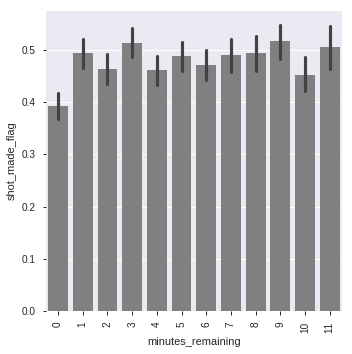

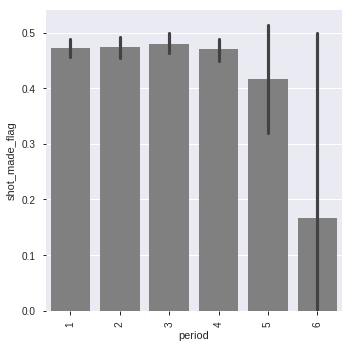

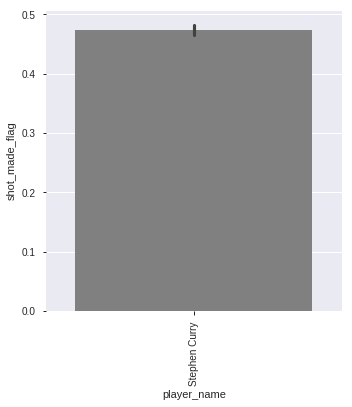

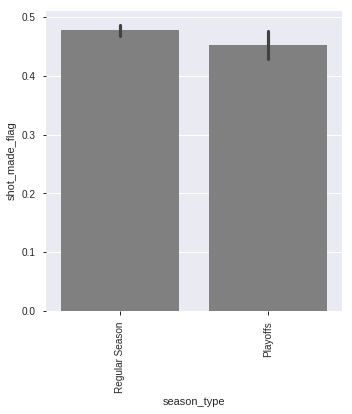

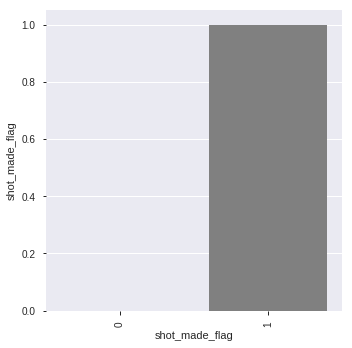

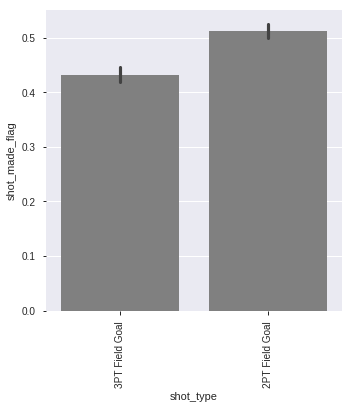

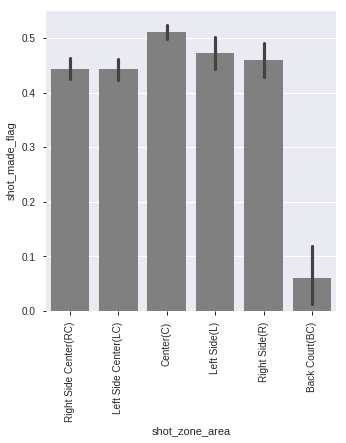

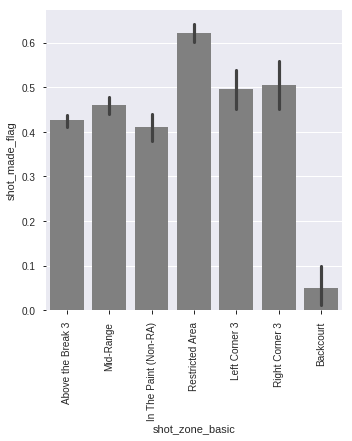

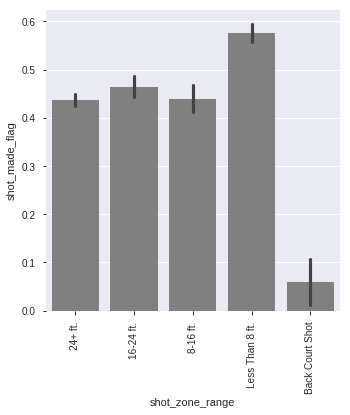

In [0]:
# Plotting categorical features vs. target

import seaborn as sns
import matplotlib.pyplot as plt
        
for col in sorted(train.columns):
  if train[col].nunique() < 20:
    sns.catplot(x = col, y = 'shot_made_flag', data = train, kind = 'bar', color = 'grey')
    plt.xticks(rotation='vertical')
    plt.show()

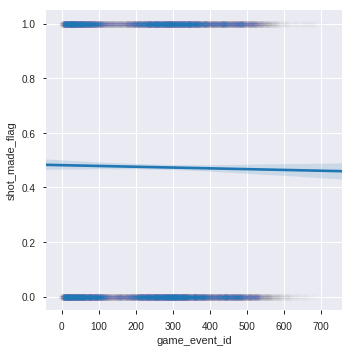

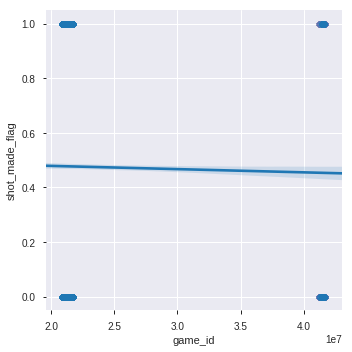

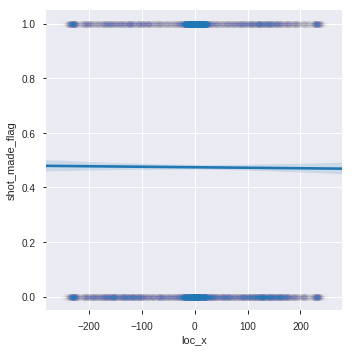

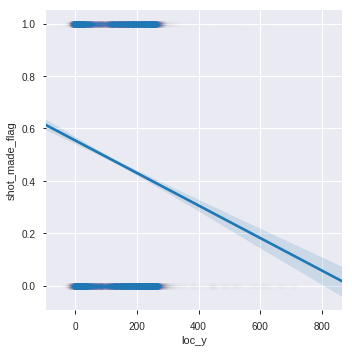

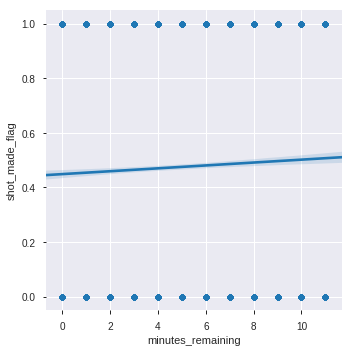

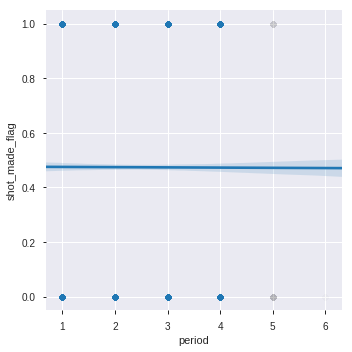

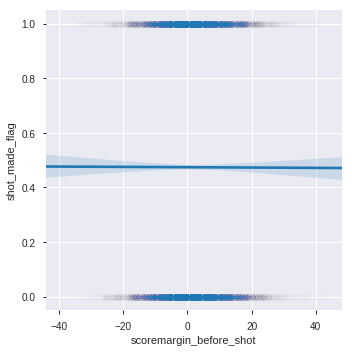

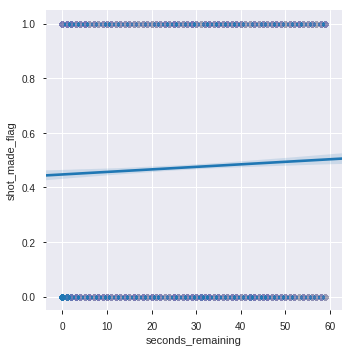

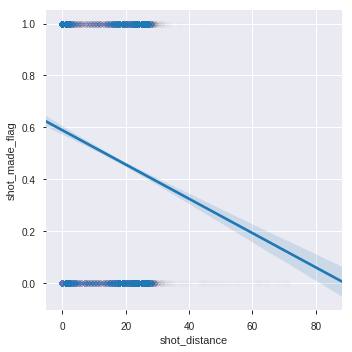

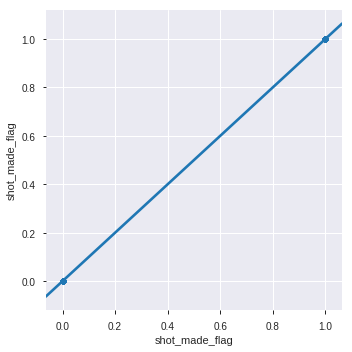

In [0]:
# Plotting numerical features vs. target
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='shot_made_flag', data=train, scatter_kws=dict(alpha=0.002))
    plt.show()

In [0]:
# Making engineer function
def engineer(df):
  df = df.copy()
  
#   creating opp_team feature
  def opp_team(row):
    if row['htm'] == 'GSW':
        opp_team = row['vtm']
    else:
        opp_team = row['htm']
    return opp_team

  df['opp_team'] = df.apply(opp_team, axis = 1)
  
#   creating homecourt feature
  df['homecourt'] = 1*(df['htm']=='GSW')
  
  #   making seconds remaining in period variable
  df['seconds_remaining_period'] = (df.minutes_remaining*60) + df.seconds_remaining
  #   making seconds remaining game variable
  df['seconds_remaining_game'] = ((4-df.period)*12*60)+df.seconds_remaining_period
  
  #   making made previous shot variable
  previous = df.copy().shift(1)
  df['made_previous'] = previous.shot_made_flag
  df['made_previous'][0] = 0 # imputing missing first value
  
  
  df['day'] = df['game_date'].dt.day
  df['month'] = df['game_date'].dt.month
  df['year'] = df['game_date'].dt.day
  df['day_of_week'] = df['game_date'].dt.dayofweek
  df = df.drop(['game_date'], axis='columns')
  return df

In [0]:
# Applying functions

train = engineer(train)
test = engineer(test)


test.head(30)

game_id  game_event_id    player_name  ...  month  year  day_of_week
12249  21800002             10  Stephen Curry  ...     10    16            1
12250  21800002             58  Stephen Curry  ...     10    16            1
12251  21800002            131  Stephen Curry  ...     10    16            1
12252  21800002            141  Stephen Curry  ...     10    16            1
12253  21800002            145  Stephen Curry  ...     10    16            1
12254  21800002            276  Stephen Curry  ...     10    16            1
12255  21800002            293  Stephen Curry  ...     10    16            1
12256  21800002            368  Stephen Curry  ...     10    16            1
12257  21800002            374  Stephen Curry  ...     10    16            1
12258  21800002            418  Stephen Curry  ...     10    16            1
12259  21800002            470  Stephen Curry  ...     10    16            1
12260  21800002            474  Stephen Curry  ...     10    16            1
12261  21800002            478  Stephen Curry  ...     10    16            1
12262  21800002            509  Stephen Curry  ...     10    16            1
12263  21800002            533  Stephen Curry  ...     10    16            1
12264  21800002            537  Stephen Curry  ...     10    16            1
12265  21800002            547  Stephen Curry  ...     10    16            1
12266  21800002            649  Stephen Curry  ...     10    16            1
12267  21800002            654  Stephen Curry  ...     10    16            1
12268  21800002            724  Stephen Curry  ...     10    16            1
12269  21800024             35  Stephen Curry  ...     10    19            4
12270  21800024             94  Stephen Curry  ...     10    19            4
12271  21800024            120  Stephen Curry  ...     10    19            4
12272  21800024            124  Stephen Curry  ...     10    19            4
12273  21800024            255  Stephen Curry  ...     10    19            4
12274  21800024            304  Stephen Curry  ...     10    19            4
12275  21800024            314  Stephen Curry  ...     10    19            4
12276  21800024            321  Stephen Curry  ...     10    19            4
12277  21800024            378  Stephen Curry  ...     10    19            4
12278  21800024            390  Stephen Curry  ...     10    19            4

[30 rows x 28 columns]

In [0]:
test.fillna(0, inplace=True)
test.head()

game_id  game_event_id    player_name  ...  month  year  day_of_week
12249  21800002             10  Stephen Curry  ...     10    16            1
12250  21800002             58  Stephen Curry  ...     10    16            1
12251  21800002            131  Stephen Curry  ...     10    16            1
12252  21800002            141  Stephen Curry  ...     10    16            1
12253  21800002            145  Stephen Curry  ...     10    16            1

[5 rows x 28 columns]

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn or xgboost cross-validation method.

In [0]:
# Validating using train/validate/test split with random 80/20 split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train.drop('shot_made_flag', axis = 'columns'),train.shot_made_flag, test_size = .20, stratify = train.shot_made_flag)

In [0]:
train.describe(exclude = 'number')

player_name action_type  ...     season_type opp_team
count           12249       12249  ...           12249    12249
unique              1          52  ...               2       31
top     Stephen Curry   Jump Shot  ...  Regular Season      HOU
freq            12249        5916  ...           10506      727

[4 rows x 10 columns]

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree, Random Forest, or Gradient Boosting model.

In [0]:
X_train.dtypes

game_id                       int64
game_event_id                 int64
player_name                  object
period                        int64
minutes_remaining             int64
seconds_remaining             int64
action_type                  object
shot_type                    object
shot_zone_basic              object
shot_zone_area               object
shot_zone_range              object
shot_distance                 int64
loc_x                         int64
loc_y                         int64
htm                          object
vtm                          object
season_type                  object
scoremargin_before_shot     float64
opp_team                     object
homecourt                     int64
seconds_remaining_period      int64
seconds_remaining_game        int64
made_previous               float64
day                           int64
month                         int64
year                          int64
day_of_week                   int64
dtype: object

In [0]:
# Making pipeline and fitting RandomForestClassifier 
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
  ce.OrdinalEncoder()
  , RandomForestClassifier(n_estimators = 2000, min_samples_leaf = 9, max_depth = 33, n_jobs = -1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type', 'opp_team'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtyp...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=33,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                 

In [0]:
# Using randomizedserchCV to optimize hyperparameaters

from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'randomforestclassifier__n_estimators': randint(100, 3000), 
    'randomforestclassifier__max_depth': randint(5, 50), 
    'randomforestclassifier__min_samples_leaf': randint(1,75)
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=2, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.2min remaining:    0.0s


In [0]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
5      13.429120      0.374252  ...          0.888763         0.007155
7      16.892475      0.149211  ...          0.781203         0.004876
2      10.258134      0.163463  ...          0.792326         0.001305
4      19.746557      0.267913  ...          0.735178         0.011301
0      21.175732      0.004977  ...          0.658231         0.008231
8      12.027045      0.125306  ...          0.667314         0.011396
9      21.500510      0.144154  ...          0.704563         0.015175
3      18.588004      0.104045  ...          0.668437         0.013131
6      13.971763      0.130812  ...          0.664865         0.010375
1       6.530652      0.005691  ...          0.669968         0.012212

[10 rows x 17 columns]

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [0]:
from sklearn.metrics import accuracy_score
y_pred = search.best_estimator_.predict(X_val)
print('Validation Accuracy', accuracy_score(y_pred, y_val))

Validation Accuracy 0.6616326530612245


## 7. Get and plot your model's feature importances.

In [0]:
model = search.best_estimator_
type(model)

sklearn.pipeline.Pipeline

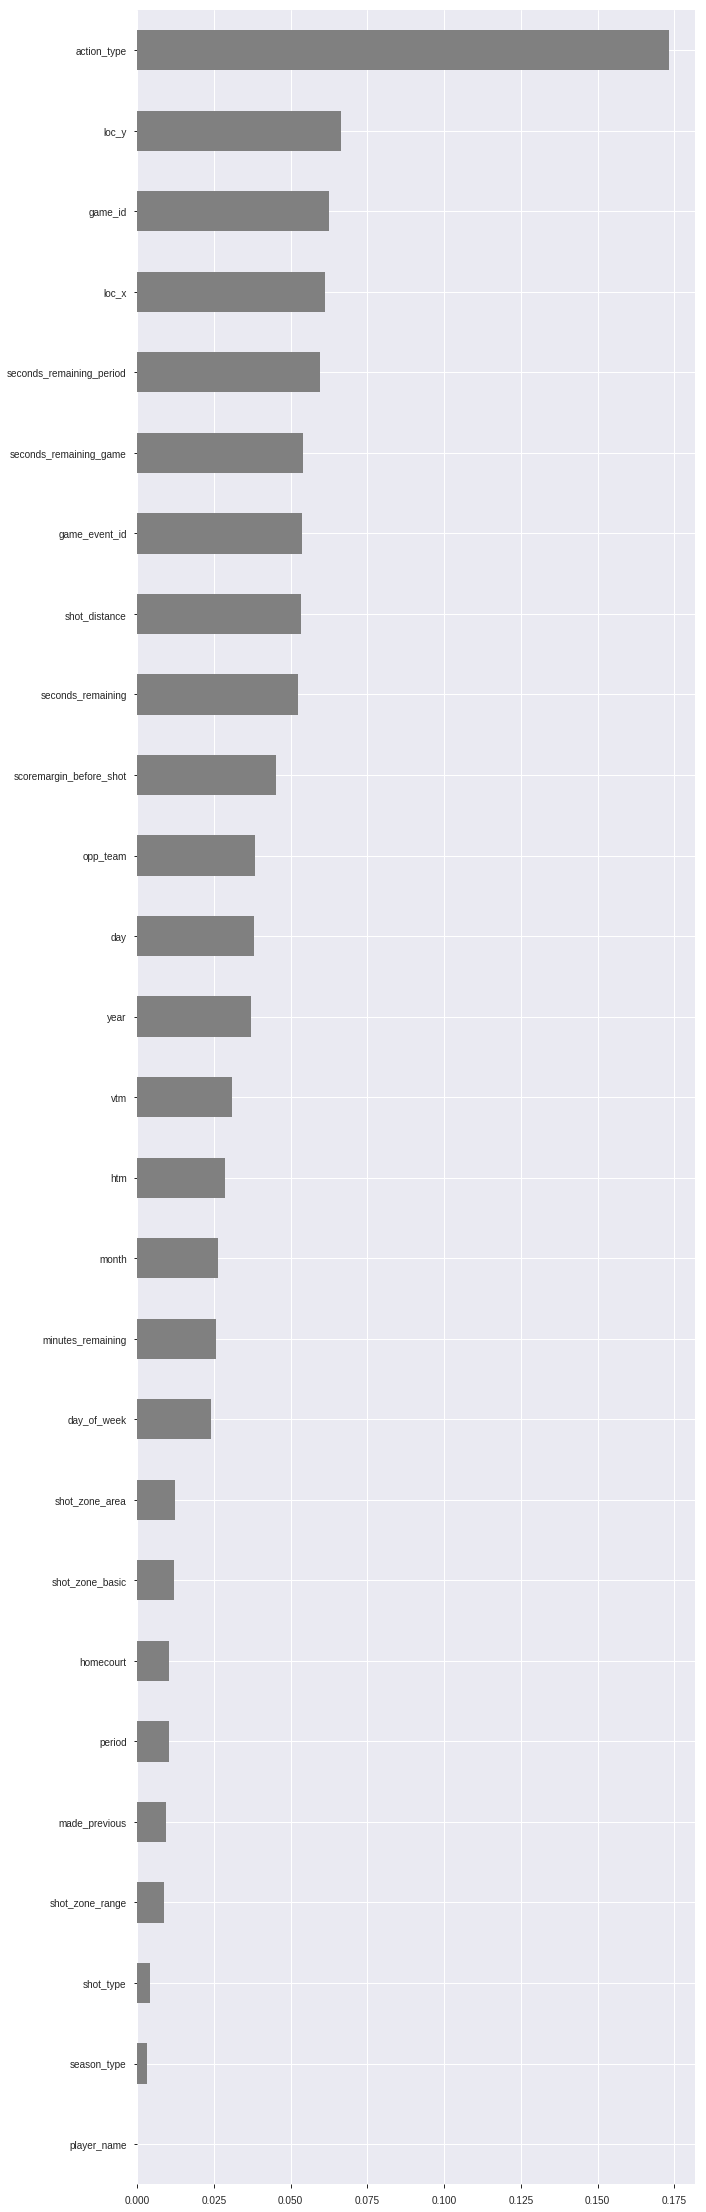

In [0]:
# plotting feature importances
import matplotlib.pyplot as plt

importances = pd.Series(search.best_estimator_.named_steps.randomforestclassifier.feature_importances_, X_train.columns)
plt.figure(figsize = (10,40))
importances.sort_values().plot.barh(color = 'gray');

## 8. Get and display your model's permutation importances.

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = search.best_estimator_.named_steps.randomforestclassifier
model.fit(X_train_encoded,y_train)

permuter = PermutationImportance(model
                ,scoring = 'accuracy'
                ,n_iter = 2)
permuter.fit(X_val_encoded, y_val)
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top = None, feature_names=feature_names)

In [0]:
# Using permutation importance for feature selection

minimum_importance = 0
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)

X_val = X_val[features]

Shape after removing features: (9799, 4)


In [0]:
# Doing RandomizedSearchCV again with bad features removed

param_distributions = {
    'randomforestclassifier__n_estimators': randint(100, 3000), 
    'randomforestclassifier__max_depth': randint(5, 50), 
    'randomforestclassifier__min_samples_leaf': randint(1,75)
}



search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=2, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s


KeyError: ignored

## 9. Get your model's test accuracy

> (One time, at the end.)

In [0]:
X_test = test.drop('shot_made_flag', axis = 'columns')
y_test = test['shot_made_flag']
X_test.head()



game_id  game_event_id    player_name  ...  month  year  day_of_week
12249  21800002             10  Stephen Curry  ...     10    16            1
12250  21800002             58  Stephen Curry  ...     10    16            1
12251  21800002            131  Stephen Curry  ...     10    16            1
12252  21800002            141  Stephen Curry  ...     10    16            1
12253  21800002            145  Stephen Curry  ...     10    16            1

[5 rows x 27 columns]

In [0]:
y_pred = pipeline.predict(X_test)
print('Validation Accuracy', accuracy_score(y_pred, y_test))

Validation Accuracy 0.6290228203627852


In [0]:
X_test.seconds_remaining.dtypes

X_test['test'] = X_test.seconds_remaining/7


In [0]:
X_test.drop('test', axis = 'columns', inplace = True)


In [0]:
X_test.head()

game_id  game_event_id    player_name  ...  month  year  day_of_week
12249  21800002             10  Stephen Curry  ...     10    16            1
12250  21800002             58  Stephen Curry  ...     10    16            1
12251  21800002            131  Stephen Curry  ...     10    16            1
12252  21800002            141  Stephen Curry  ...     10    16            1
12253  21800002            145  Stephen Curry  ...     10    16            1

[5 rows x 27 columns]

In [0]:
df['fraction'] = df[[df.shot_zone_basic.value_counts()

Above the Break 3        5695
Mid-Range                3194
Restricted Area          2692
In The Paint (Non-RA)    1250
Left Corner 3             603
Right Corner 3            428
Backcourt                  96
Name: shot_zone_basic, dtype: int64